# Deep Learning &mdash; Assignment 5

Fifth assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_October 2020_

-----

**Names:** Mick Tuit, Maurice Verbrugge

**Group:** 1

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will

1. Implement and train a generative adversarial network.
2. Experiment with reverse gradient training.
3. Implement a CycleGAN.
4. Experiment with CycleGAN optimization.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [2]:
%matplotlib inline
import csv
import glob
import re
from collections import defaultdict
import numpy as np
import scipy
import sklearn.datasets
import matplotlib.pyplot as plt
import PIL
import torch
import torch.autograd
import torchvision
import torchvision.transforms
from d2l import torch as d2l

from IPython import display

## 5.1 Moon dataset

The noisy moon dataset is a synthetic dataset with the following distribution:

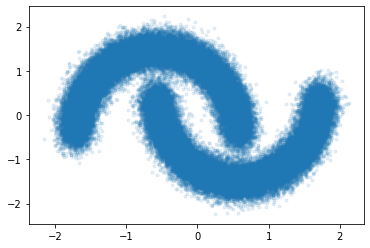

In [3]:
n_samples = 100000
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons[0][:, 0] -= np.mean(noisy_moons[0][:, 0])
noisy_moons[0][:, 0] /= np.std(noisy_moons[0][:, 0])
noisy_moons[0][:, 1] -= np.mean(noisy_moons[0][:, 1])
noisy_moons[0][:, 1] /= np.std(noisy_moons[0][:, 1])
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], '.', alpha=0.1);

**Run the following code to convert the data to a PyTorch dataset:**

In [4]:
moon_dataset = torch.utils.data.TensorDataset(torch.tensor(noisy_moons[0], dtype=torch.float32),
                                              torch.tensor(noisy_moons[1], dtype=torch.float32))

## 5.2 Generator

We define a generator that generates samples from a learned distribution, based on a random noise input.

The generator accepts 1D input vector with 100 elements and has to output a 1D vector with 2 elements.

In [5]:
class MoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)

**Generate some samples from this generator before training and plot the resulting distribution.**

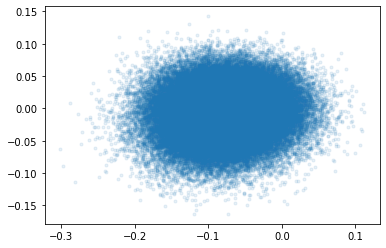

In [6]:
gen = MoonGenerator()
x = torch.rand((n_samples, 100)) * 2 - 1
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.1);

## 5.3 Untrainable dummy generator network

For our experiments, we also define an untrainable dummy generator network that produces samples from a uniform distribution. We'll use this later to investigate what our discriminator learns.

In [7]:
class UniformMoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dummy_param = torch.nn.Parameter(torch.tensor([0.]))

    def forward(self, x):
        return torch.rand((x.shape[0], self.output_size),
                          device=x.device, dtype=x.dtype) * 4 - 2

**Run the code to generate some samples from this generator and plot the resulting distribution.**

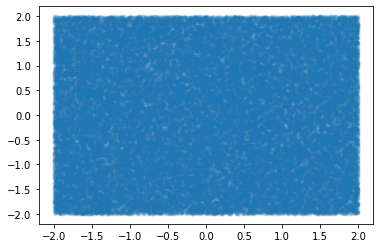

In [8]:
gen = UniformMoonGenerator()
x = torch.randn((n_samples, 100))
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.1);

## 5.4 Discriminator

To train the generator, we need a discriminator that takes the samples from the generator and samples from the real distribution. For real samples, the discriminator should predict 1, for fake samples it should predict 0.

For stability, we will exclude the final sigmoid activation from the discriminator and use the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) function during training.

**Complete the discriminator below:** (Already done, see update from Brightspace)

Some of your eagle-eyed colleagues pointed out that the discriminator is already fully implemented, so there's nothing to do. This is correct: you don't have to add anything to the code. (I think this happened because I first wanted to let you implement this, but later changed my mind.)

In [9]:
class MoonDiscriminator(torch.nn.Module):
    def __init__(self, inputs=2, hiddens=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, 1)
        )
        # Note: Although this is a binary classifier, we do not yet apply
        #       a sigmoid activation here. Instead, we'll use the
        #       BCEWithLogitsLoss later to compute sigmoid + BCE loss in
        #       a numerically stable way.

    def forward(self, x):
        return self.net(x)

## 5.5 Plot discriminator

We can plot the value of the discriminator in our sample space to see what it is doing.

**Run the code to plot the of an untrained discriminator:**

(250000, 1)
torch.Size([500, 500])


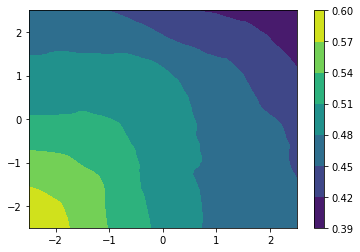

In [10]:
def plot_discriminator(discriminator, xmin=-2.5, xmax=2.5, steps=500):
    x0, x1 = torch.meshgrid(torch.linspace(xmin, xmax, steps=steps),
                            torch.linspace(xmin, xmax, steps=steps))
    x = torch.stack([x0.flatten(), x1.flatten()], axis=1)
    y = discriminator(x)
    y = torch.sigmoid(y).detach().cpu().numpy()
    print(y.shape)
    print(x0.shape)
    y = y.reshape(x0.shape)
    plt.contourf(x0, x1, y)
    plt.colorbar()

disc = MoonDiscriminator()
plot_discriminator(disc)

**Which values/shape do you expect to see in a trained discriminator?**

DONE Your answer here. Maurice kun je even checken? Weet dit niet zeker, je zou idd 0 en 1 verwachten... ik ben nog even aan het lezen over discriminators, wat die zouden moeten opleveren maar ik heb nu even college

When you have a trained discriminator, you would like it to only output values of 1 or 0. The shape should probably look like the distribution of the real data, ie. contain 1's in the shape of the moons. 

## 5.6 Adversarial training loop

Now we have a generator and a discriminator, we can attempt to train the model. We will define a training function that implements the adversarial training procedure:

For each minibatch of real samples:
1. Generate a batch of fake samples;
2. Compute the discriminator loss on the real and fake samples;
3. Optimize the discriminator;
4. Generate another batch of fake samples;
5. Compute the generator loss on the fake samples;
6. Update the generator.

To monitor training, we'll print the discriminator and accuracy loss. We'll also monitor the accuracy of the discriminator (the percentage of correctly labeled real and fake samples) and the 'accuracy' of the generator (the percentage of fake samples incorrectly labeled as real by the discriminator).

**Complete the training loop below:**

In [11]:
def train_adversarial(generator, discriminator, data_loader, epochs=10,
                      lr_gen=0.001, lr_disc=0.001, device=d2l.try_gpu()):
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen)
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_disc)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        epoch_disc_acc = 0
        epoch_gen_acc = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            ## 1. Discriminator
            # generate noise for the generator
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            # generate fake samples
            x_fake = generator(rand_for_gen)

            # run discriminator on real and fake samples
            d_real = discriminator(x_real)
            d_fake = discriminator(x_fake)

            # compute discriminator loss
            # - for real samples, the discriminator should predict 1
            # - for fake samples, the discriminator should predict 0
            disc_loss = (bce_logits_loss(d_real, torch.ones_like(d_real)) +
                         bce_logits_loss(d_fake, torch.zeros_like(d_fake)))
            disc_acc = (torch.mean((d_real > 0).to(torch.float)) +
                        torch.mean((d_fake < 0).to(torch.float))) / 2

            # update discriminator
            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()


            ## 2. Generator
            # generate another batch of fake samples
            rand_for_gen = torch.rand((x_real.shape[0], gen.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # compute generator loss
            d_fake = discriminator(x_fake)
            # DONE: compute the generator loss using d_fake and bce_logits_loss
            #       and the appropriate target value (see the implementation for
            #       the discriminator loss)
            # cf docs: bce_logits_loss(output, target)
            # - for fake generated samples, the discriminator should predict 1
            gen_loss = bce_logits_loss(d_fake, torch.ones_like(d_fake))
            # for the generator, we compute how many generated samples were given
            # the label 'real' by the discriminator
            gen_acc = torch.mean((d_fake > 0).to(torch.float))

            # update generator
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            ## 3. Statistics
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            epoch_disc_acc += disc_acc.item()
            epoch_gen_acc += gen_acc.item()
            mb_count += 1

        print('Epoch %d: disc_loss=%f gen_loss=%f  disc_acc=%f gen_acc=%f' %
              (epoch, epoch_disc_loss / mb_count, epoch_gen_loss / mb_count,
               epoch_disc_acc / mb_count, epoch_gen_acc / mb_count))

## 5.7 Experiment: Train the discriminator only

First, we'll train the discriminator only, using the dummy generator to generate samples from a uniform distribution.

**Run the code to train the discriminator:**

In [12]:
device = d2l.try_gpu()
gen = UniformMoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

disc.to('cpu')
gen.to('cpu');

Epoch 0: disc_loss=0.982627 gen_loss=2.904178  disc_acc=0.755759 gen_acc=0.354610
Epoch 1: disc_loss=0.902247 gen_loss=3.613771  disc_acc=0.787394 gen_acc=0.303808
Epoch 2: disc_loss=0.896250 gen_loss=3.706764  disc_acc=0.788858 gen_acc=0.308674
Epoch 3: disc_loss=0.890153 gen_loss=3.757640  disc_acc=0.790506 gen_acc=0.309303
Epoch 4: disc_loss=0.891779 gen_loss=3.783326  disc_acc=0.790396 gen_acc=0.309972
Epoch 5: disc_loss=0.889140 gen_loss=3.909337  disc_acc=0.791141 gen_acc=0.310192
Epoch 6: disc_loss=0.887049 gen_loss=3.931573  disc_acc=0.791585 gen_acc=0.309013
Epoch 7: disc_loss=0.888775 gen_loss=3.989034  disc_acc=0.791410 gen_acc=0.307695
Epoch 8: disc_loss=0.885438 gen_loss=3.994840  disc_acc=0.791925 gen_acc=0.312050
Epoch 9: disc_loss=0.886497 gen_loss=3.974298  disc_acc=0.791620 gen_acc=0.309783


**Plot the discriminator output and inspect the result:**

(250000, 1)
torch.Size([500, 500])


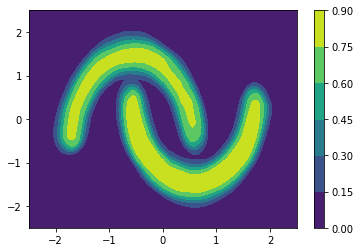

In [13]:
plot_discriminator(disc)

**Briefly discuss this result. Why does the discriminator learn this?**

DONE: What we see here is very similar to the initial dataset from sklearn. Basically the discriminator learns the shape it gets presented because it gets penalized for guessing 'wrong'

**Does the discriminator reach 100% classification accuracy? Why, or why not?**

DONE: The original dataset is a distribtion so on the 'edges' some pixels are 1 and others 0, this gives a blurred line, so the discriminator could never reach 100% accuracy, because is should set a threshold.

## 5.8 Experiment: Train the generator and discriminator

We'll now train the model with the trainable generator.

**Train the generator and discriminator together:**

In [14]:
device = d2l.try_gpu()
gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

disc.to('cpu')
gen.to('cpu');

Epoch 0: disc_loss=0.953796 gen_loss=1.552179  disc_acc=0.757922 gen_acc=0.207401
Epoch 1: disc_loss=1.179044 gen_loss=1.027286  disc_acc=0.656080 gen_acc=0.262378
Epoch 2: disc_loss=1.295572 gen_loss=0.868535  disc_acc=0.601827 gen_acc=0.326527
Epoch 3: disc_loss=1.336059 gen_loss=0.799648  disc_acc=0.573559 gen_acc=0.355239
Epoch 4: disc_loss=1.348639 gen_loss=0.775306  disc_acc=0.561011 gen_acc=0.371234
Epoch 5: disc_loss=1.366588 gen_loss=0.732125  disc_acc=0.536190 gen_acc=0.385110
Epoch 6: disc_loss=1.375955 gen_loss=0.714741  disc_acc=0.518123 gen_acc=0.409787
Epoch 7: disc_loss=1.381185 gen_loss=0.706081  disc_acc=0.509666 gen_acc=0.448589
Epoch 8: disc_loss=1.385357 gen_loss=0.697121  disc_acc=0.500949 gen_acc=0.476562
Epoch 9: disc_loss=1.385683 gen_loss=0.698089  disc_acc=0.504671 gen_acc=0.484555


**Run the code below to plot the generated samples, the discriminator output, and the real samples.**

(250000, 1)
torch.Size([500, 500])


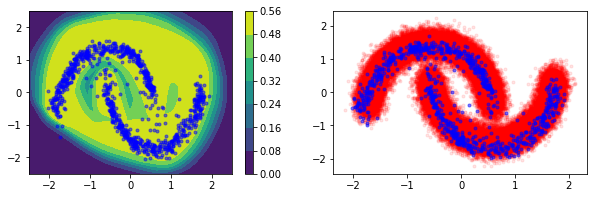

In [15]:
def plot_generator(generator, n_samples=1000):
    x = torch.rand((n_samples, 100)) * 2 - 1
    y = generator(x).detach().cpu().numpy()
    plt.plot(y[:, 0], y[:, 1], 'b.', alpha=0.5)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_discriminator(disc)
plot_generator(gen)
plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen)

**Briefly discuss this result.**

DONE Your answer here.

What you see on the left is a plot of the discriminator with an overlay of the generated samples by the generator. In the right plot we see real noisy_moons dataset (in red) with an overlay of the generated samples by the generator. 

Compare the output of the new discriminator with the output of the discriminator trained without a generator.

**Are the discriminator outputs the same? Why does this happen?**

DONE Your answer here.

The output are not the same. On the left side the generator succeeded in stretching the boundaries of the discrimator.

**Does the discriminator still reach a high accuracy? Why (not?)**

DONE Your answer here.

No, this is considerably lower (min 0.3). This is because the generator is now generating samples which are testing the boundaries of the discriminator, therefore the descriminator has a much harder job of predicting if it is real or fake. This is reflected in the decrease of the accuracy. 

**How should we interpret the accuracy for the discriminator and the 'accuracy' for the generator? How can we see if the model is working well?**

DONE Your answer here.

They both reach a score around 50%, however when inspecting visually: the generator clearly does a better job. The discriminator accepts samples that are way out of line. If the accuracy of the discriminator is low and generator is high it means that the generator is fooling the discriminator with great succes. Vice versa, this means that the discriminator is able to tell apart real samples from fake samples. To see if the model is working well we need to define what we want of the model. It's hard to see if the model is working well, since a low accuracy discriminator and high for generator could also mean that the discriminator is just really bad. Therefore you would want to have a sort of balance where they can keep improving each other. 

**Compare the distribution learned by the generator with the real distribution. Are they the same? Why does this happen?**

DONE Your answer here.

No they are not the same, the generator distribution is 'smaller'. Around the area's in the centre where the moons come together the generator has samples which are not in the distribution, but between the two. This is probably because the generator is testing the boundaries of the generator in the hard spots. 

**The clusters in the generated distribution look a bit 'thinner' or less spread-out than those in the real distribution: most samples are concentrated in the center of the curves. Can you explain this? How could you solve this problem?**

DONE Your answer here.

The reason for this could possibly be that the samples at the edge of the curve are easier to predict of being fake or real. Perhaps this could be solved by using feature matching. 

## 5.9 Gradient reversal

As an alternative to training the discriminator and generator separately, we can also train the model with a gradient reversal layer that reverses the gradient coming from the discriminator:

```
Forward: generator -> discriminator.
Backward: generator gradient <- gradient reversal <- discriminator gradient.
```

In PyTorch, we'll implement this as a function `revgrad(x)` that will reverse the gradient that passes through it. You can use it like this:
```
y = discriminator(revgrad(generator(x)))
loss = loss_fn(y, target)
loss.backward()
```

**Run the code to define the `revgrad` gradient reversal function:**

In [19]:
class RevGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_): 
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = -grad_output
        return grad_input

revgrad = RevGrad.apply

The training loop is now a bit simpler than before, because we do not have to compute the generator loss separately.

**Inspect the new training function:** -> Should be **"Complete the new training function"**, comment on Brightspace

In [20]:
def train_adversarial_revgrad(generator, discriminator, data_loader, epochs=10, lr=0.001, device=d2l.try_gpu()):
    parameters = list(generator.parameters()) + list(discriminator.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc_real = 0
        epoch_acc_fake = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            # generate fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # run discriminator on real and random samples,
            # reverse the gradient for the generator
            d_real = discriminator(x_real)
            # TODO: compute the discriminator output like before,
            #       but include the gradient reversal layer
            d_fake = discriminator(revgrad(x_fake))

            # compute loss
            loss_real = bce_logits_loss(d_real, torch.ones_like(d_real))
            loss_fake = bce_logits_loss(d_fake, torch.zeros_like(d_fake))
            loss = loss_real + loss_fake
            
            # compute discriminator accuracy
            acc_real = torch.mean((d_real > 0).to(torch.float))
            acc_fake = torch.mean((d_fake < 0).to(torch.float))

            # update generator and discriminator
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_loss += loss.item()
            epoch_acc_real += acc_real.item()
            epoch_acc_fake += acc_fake.item()
            mb_count += 1

        print('Epoch %d: loss=%f  acc_real=%f acc_fake=%f' %
              (epoch, epoch_loss / mb_count,
               epoch_acc_real / mb_count, epoch_acc_fake / mb_count))

## 5.10 Experiment: Training with gradient reversal

**Train a generator and discriminator with the new training function:**

In [23]:
device = d2l.try_gpu()
gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial_revgrad(gen, disc, loader, epochs=10, lr=0.001, device=device)

disc.to('cpu')
gen.to('cpu');

**Plot and inspect the results:**

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_discriminator(disc)
plot_generator(gen)

plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen)

**Briefly discuss the result.**

TODO Your answer here.

**What are some advantages and disadvantages of the gradient reversal layer, compared with the previous two-step approach?**

TODO Your answer here.

## 5.11 Emoji dataset

For the second part of this assignment we will borrow an emoji dataset (and some ideas) from a course at [the University of Toronto](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/).

The dataset contains images of Apple-style and Windows-style emojis. You can [download the files](http://www.cs.toronto.edu/~jba/emojis.tar.gz) yourself or use the code below.

**Download the dataset and extract the files:**

In [22]:
!cd /data
# !wget -c http://www.cs.toronto.edu/~jba/emojis.tar.gz
# !tar xzf emojis.tar.gz

We'll resize the images to 32 by 32 pixels and normalize the RGB intensities to values between -1 and 1.

**Run the code to construct the datasets:**

In [ ]:
def image_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGBA')[0:3, :, :]

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

d_windows = torchvision.datasets.ImageFolder('emojis/Windows/', transform)
d_apple = torchvision.datasets.ImageFolder('emojis/Apple/', transform)

**Plot a few images to see the different styles:**

In [ ]:
def image_grid(d, idxs):
    images = [d[idx][0] for idx in idxs]
    grid = torchvision.utils.make_grid(images)
    return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_grid(d_windows, range(100, 140)))
plt.title('Windows')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_grid(d_apple, range(400, 440)))
plt.title('Apple')
plt.axis('off')
plt.tight_layout()

## 5.12 CycleGAN

We'll try to train a CycleGAN that can translate emojis between the Windows and Apple styles.

This CycleGAN has the following components:
* A generator that translates from Windows to Apple;
* A generator that translates from Apple to Windows;
* A discriminator that discriminates between real and fake emojis from the Windows distribution;
* A discriminator that discriminates between real and fake emojis from the Apple distribution.

### Generator

First, we define the generator. We'll use the same generator architecture for both directions. Unlike before, the generator does not take random noise as input, but expects a 32 by 32 RGB image as input and returns a 32 by 32 RGB image as output.

The generator has the following structure:
```
- Input: 32x32 pixels, 3 channels.
- Two downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 32 -> 64 channels.
- One convolution block in the middle:
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 64 channels.
- Two upsampling + convolution blocks:
  upsampling (scale factor 2) followed by convolution,
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 32 -> 3 channels.
- Output: 32x32 pixels, 3 channels.
```

Add batch normalization and ReLU after each convolution, except at the end.

The images have a [-1, +1] range, so the last output should use a tanh activation without BN.

**Complete the code below:**

In [ ]:
class CycleGenerator(torch.nn.Module):
    def __init__(self, input_size=100):
        super().__init__()
        self.input_size = input_size
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 pixels
            # TODO: implement the downsampling part as described above

            # no downsampling, no upsampling
            torch.nn.Conv2d(64, 64, (5, 5), padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            # upsampling 8 -> 16 -> 32 pixels
            # TODO: complete the upsampling part as described above
            
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(32, 3, (5, 5), stride=1, padding=2),
            torch.nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

# the output should have the same shape as the input
CycleGenerator()(torch.zeros((30, 3, 32, 32))).shape

### Discriminator

The discriminator is similar in concept to what we had in the GAN model: it takes an image and predicts 1 for a real image and 0 for a fake.

```
- Input: 32x32 pixels, 3 channels.
- Three downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 64 -> 64 -> 64 channels.
- One fully connected layer from (64*4*4) to 1.
- Output: 1 output element.
```

Add batch normalization and ReLU after each convolution, except at the end of the network.

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 -> 4
            torch.nn.Conv2d(3, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(64 * 4 * 4, 1)
        )
        # Note: Although this is a binary classifier, we do not apply
        #       a sigmoid activation here. We'll optimize a mean-squared
        #       error to make the discriminator's task a bit harder and
        #       get a slightly better gradient.

    def forward(self, x):
        return self.net(x)

# the output shape should be (30, 1)
Discriminator()(torch.zeros((30, 3, 32, 32))).shape

## 5.13 CycleGAN training loop

The training loop for the GAN with cycle-consistency loss follows the following procedure:

For each batch of samples from domain A and B:
* Use the generators to predict the fake B given A, and fake A given B.
* Use the generators to reconstruct A given fake B, and B given fake A.

The discriminator loss is composed of:
* The discriminator losses for real samples from A and B.
* The discriminator losses for fake samples from A and B.

The cycle-consistency loss is composed of:
* The reconstruction loss comparing the real A with the cycled A->B->A.
* The reconstruction loss comparing the real B with the cycled B->A->B.

Finally, the two groups losses are combined with a weight `lambda_cycle` for the cycle-consistency loss:

```loss = discriminator_loss + lambda_cycle * cycle-consistency loss```

**Complete the code below to implement this procedure:**

In [ ]:
def train_cycle(generator_ab, generator_ba, discriminator_a, discriminator_b,
                data_loader_a, data_loader_b,
                epochs=10, lr=0.001, lambda_cycle=0.1, device=d2l.try_gpu()):
    mse_loss = torch.nn.MSELoss()
    models = torch.nn.ModuleList([generator_ab, generator_ba, discriminator_a, discriminator_b])
    optimizer = torch.optim.Adam(models.parameters(), lr=lr, betas=(0.5, 0.999))
    
    plt.figure(figsize=(10, 15))

    for epoch in range(epochs):
        epoch_stats = defaultdict(lambda: 0)
        mb_count = 0

        disc_a.train()
        disc_b.train()
        gen_ab.train()
        gen_ba.train()

        for (real_a, _), (real_b, _) in zip(loader_a, loader_b):
            # Change to device, see forum on Brightspace
            real_a = real_a.to(device) # real_a = real_a.to('cuda')
            real_b = real_b.to(device) # real_b = real_b.to('cuda')
            
            # compute fake images A->B->A
            fake_ab = generator_ab(real_a)
            cycle_aba = generator_ba(fake_ab)

            # compute fake images B->A->B
            fake_ba = generator_ba(real_b)
            cycle_bab = generator_ab(fake_ba)

            # run discriminator on real and fake images
            d_real_a = discriminator_a(real_a)
            # TODO: compute other discriminator output, use gradient reversal where necessary
            d_real_b = ...   # TODO
            d_fake_ba = ...  # TODO
            d_fake_ab = ...  # TODO

            # compute discriminator loss
            # we optimize the MSE loss function to make the gradients of
            # the discriminator a bit easier to use
            loss_real_a = mse_loss(d_real_a, torch.ones_like(d_real_a))
            loss_real_b = ...  # TODO
            loss_fake_a = ...  # TODO
            loss_fake_b = ...  # TODO

            # compute cycle-consistency loss
            loss_cycle_a = mse_loss(cycle_aba, real_a)
            loss_cycle_b = mse_loss(cycle_bab, real_b)

            # compute loss
            loss = loss_real_a + loss_real_b + \
                   loss_fake_a + loss_fake_b + \
                   lambda_cycle * (loss_cycle_a + loss_cycle_b)

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_stats['loss'] += loss.item()
            epoch_stats['loss_real_a'] += loss_real_a.item()
            epoch_stats['loss_real_b'] += loss_real_b.item()
            epoch_stats['loss_fake_a'] += loss_fake_a.item()
            epoch_stats['loss_fake_b'] += loss_fake_b.item()
            epoch_stats['loss_cycle_a'] += loss_cycle_a.item()
            epoch_stats['loss_cycle_b'] += loss_cycle_b.item()
            mb_count += 1

        if epoch % 5 == 0:
            print('Epoch %d: ' % epoch, end='')
            for k, v in epoch_stats.items():
                print(' %s=%6.4f' % (k, v / mb_count), end='')

            images_for_plot = {
                'real_a': real_a, 'fake_ab': fake_ab, 'cycle_aba': cycle_aba,
                'real_b': real_b, 'fake_ba': fake_ba, 'cycle_bab': cycle_bab,
            }

            for k in range(10):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(10, 6, k * 6 + i + 1)
                    plt.imshow(im[k].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if k == 0:
                        plt.title(im_title)
                    plt.axis('off')
            plt.tight_layout()
            display.display(plt.gcf())
            display.clear_output(wait=True)

## 5.14 Experiment: CycleGAN training

We can now train our CycleGAN model.

**Run the code below and play with the hyperparameters if necessary to learn a reasonable output.**

Note that GANs can be very difficult to train, so don't worry if your results are not perfect. Hopefully, you will be able to get somewhat recognizable results, but it's more important that you can interpret and discuss what happens.

In [ ]:
device = d2l.try_gpu()

gen_ab = CycleGenerator().to(device)
gen_ba = CycleGenerator().to(device)
disc_a = Discriminator().to(device)
disc_b = Discriminator().to(device)

loader_a = torch.utils.data.DataLoader(d_windows, batch_size=32, shuffle=True, num_workers=4)
loader_b = torch.utils.data.DataLoader(d_apple, batch_size=32, shuffle=True, num_workers=4)

train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=1, device=device)

**Run some more experiments to study the effect of the lambda_cycle weight.**

**Discuss your results and training experience. Was the model easy to train? What do you think of the results? Does it learn a good translation between Windows and Apple emojis?**

TODO Your answer here.

**What is the effect of the lambda_cycle weight? What happens if you set it to a very large value? What happens if you set it to 0? Can you explain this?**

TODO Your answer here.

**Why is the reconstructed output (A->B->A or B->A->B) usually better than the translated output (A->B or B->A)?**

TODO Your answer here.

## 5.15 Final questions

**Discuss how the balance between the generator and discriminator affects GAN training. What can go wrong?**

TODO Your answer.

**CycleGAN and similar methods are unsupervised models that learn to map inputs from one domain to another. Is this necessarily a _semantically meaningful_ mapping? Why, or why not?** (For example, think about how our emoji model would translate flags.)

TODO Your answer.

**Bonus: Have a brief look at [CycleGAN, a Master of Steganography](https://arxiv.org/pdf/1712.02950.pdf), a paper published at NIPS 2017. The authors show that a CycleGAN network sometimes 'hides' information in the generated images, to help with the reconstruction. Can you see something like this in your results as well?**

TODO Your answer.

## The end

Well done! Please double check the instructions at the top before you submit your results.